In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne

from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram
from mne.preprocessing import (ICA, create_eog_epochs,
                               create_ecg_epochs, corrmap)
from mne.externals.pymatreader import read_mat



# raw = mne.io.read_raw_fieldtrip('RawData.mat', eeg_mat.keys())
# raw.crop(tmax=60.)

In [2]:
eeg_mat = loadmat('RawData.mat')
ch_names = [f[0] for f in eeg_mat['locations']['labels'][0]]
ch_types = ['eeg'] * (len(ch_names) - 4) + ['eog'] * 4
sampling_freq = eeg_mat['sampling_rate'].ravel()[0]

info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)

In [16]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(x)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, x)

    return Xw, whiteM

x = eeg_mat['EEG_data'] 

# Center signals
xc, ux = center(x)

# Whiten mixed signals
xw, wm = whiten(xc)

raw = mne.io.RawArray(xw * 1e-5, info)
raw

Creating RawArray with float64 data, n_channels=68, n_times=334848
    Range : 0 ... 334847 =      0.000 ...   326.999 secs
Ready.


<RawArray | 68 x 334848 (327.0 s), ~173.8 MB, data loaded>

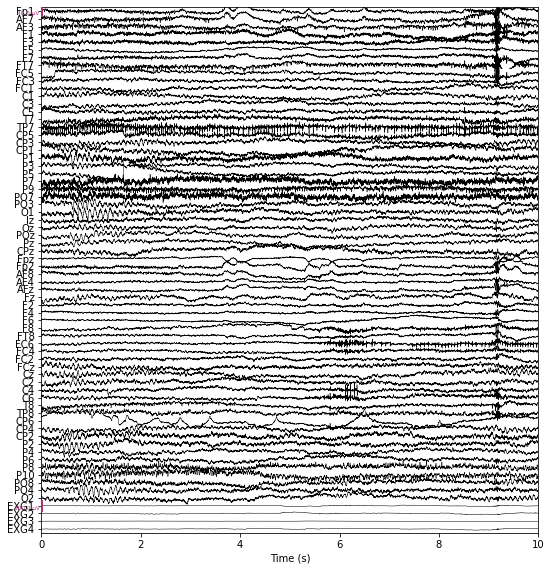

In [17]:
scalings = dict(eeg=20e-1, eog=150e-2)

plot = raw.plot(show_scrollbars=False, n_channels=68); #, scalings=scalings);

In [18]:
ica = ICA(n_components=30, max_iter='auto', random_state=55)
filt_raw = raw.copy().load_data().filter(l_freq=1., h_freq=None)
ica.fit(raw)
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/tmp/ipykernel_6823/3080963593.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 30 components
Fitting ICA took 23.8s.


Method,fastica
Fit,67 iterations on raw data (334848 samples)
ICA components,30
Explained variance,46.9 %
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=34, n_times=334848
    Range : 0 ... 334847 =      0.000 ...   326.999 secs
Ready.


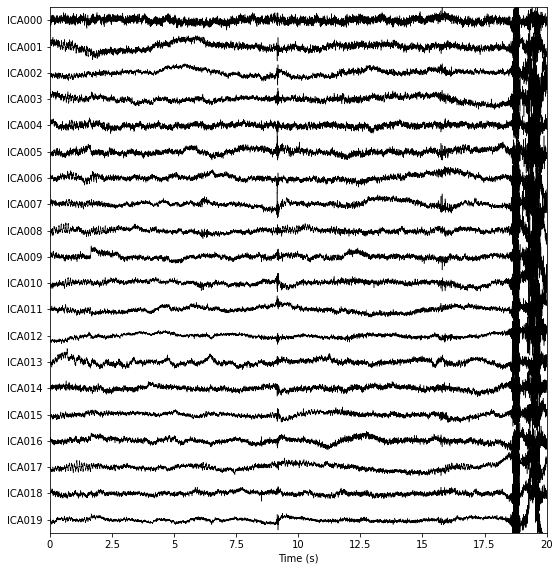

In [19]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False);

In [11]:
exclude = ica.find_bads_eog(raw)[0];
ica.exclude = exclude
exclude

Using EOG channels: EXG1, EXG2, EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff 

[16]

In [193]:
ica.get_sources(filt_raw)

<RawArray | 30 x 334848 (327.0 s), ~76.7 MB, data loaded>

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


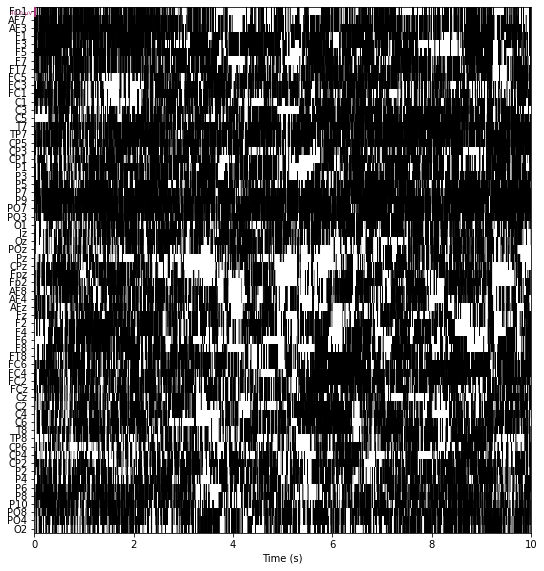

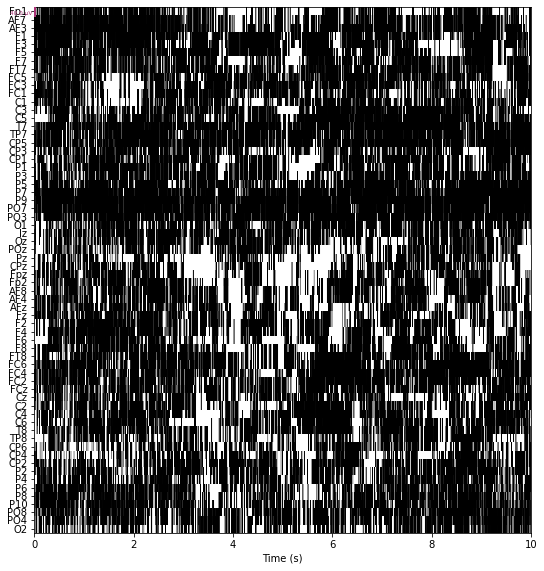

In [12]:
reconst_raw = raw.copy()
ica.apply(reconst_raw, n_pca_components=None)
raw.plot(show_scrollbars=False, n_channels=64);
reconst_raw.plot(show_scrollbars=False, n_channels=64);

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


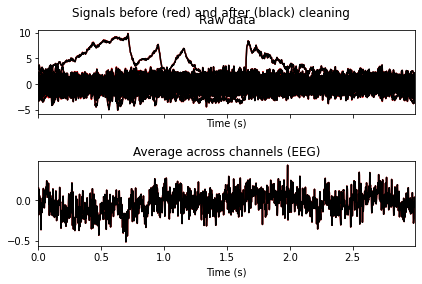

In [13]:
ica.plot_overlay(raw, exclude=exclude, picks='eeg');

In [75]:
print(eeg_mat['EEG'])
eeg_mat['EEG'];

[[(array(['E11_EEG_espontaneo_Change Sampling Rate'], dtype='<U39'), array([[1024]], dtype=uint16), array([[68]], dtype=uint8), array([[(array(['Fp1'], dtype='<U3'), array([[1]], dtype=uint8), array([[90]], dtype=uint8), array([[-39]], dtype=int16)),
          (array(['AF7'], dtype='<U3'), array([[1]], dtype=uint8), array([[-90]], dtype=int16), array([[-39]], dtype=int16)),
          (array(['AF3'], dtype='<U3'), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8)),
          (array(['F1'], dtype='<U2'), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8)),
          (array(['F3'], dtype='<U2'), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8)),
          (array(['F5'], dtype='<U2'), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8)),
      